# 2.2 Model comparison

So how do we know if a model is good? The PCNtoolkit provides us with some useful statistics for fitted models, but those aren't always as unequivocal as we would like. Luckily, for HBR models, there is a sound way to rank models, based on the WAIC. This technique allows us to configure and fit several models, and choose which one to use based on their ranking. This way, we can informatively compare models with different covariates, batch effects, likelihoods and prior settings. 


## 2.2.1 Pathological example

Here we synthesize a problematic dataset that we will use to demonstrate the inadequacy of the model statistics to show which model is best. 

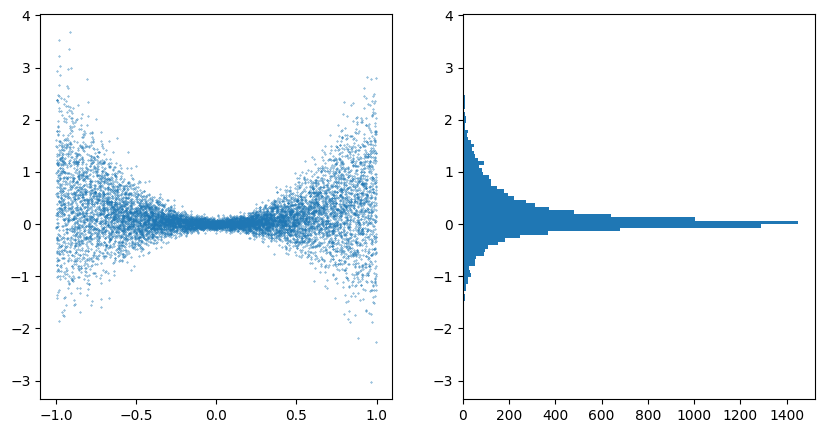

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

n_samples = 10000
x = np.random.uniform(-1, 1, n_samples)
y1 = np.random.normal(0, 1, n_samples) * (x**2 + 0.05) + x**2 / 2
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].scatter(x, y1, s=0.1)
ax[1].hist(x=y1, orientation="horizontal", bins=100)
plt.show()

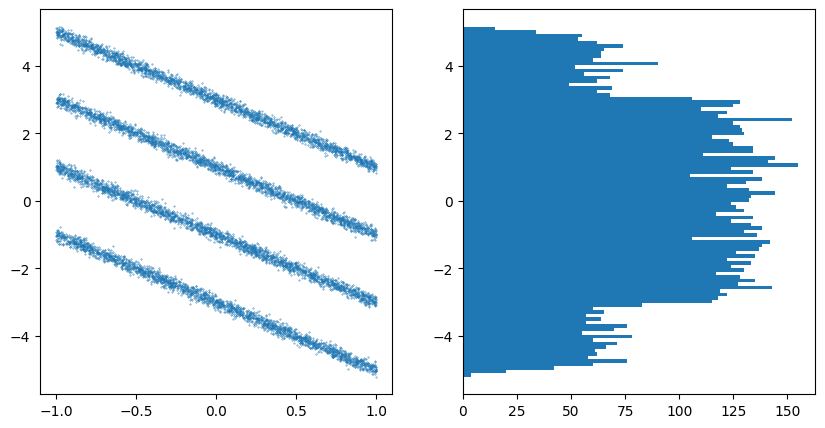

In [2]:
n_bins = 4
xsort = np.argsort(x)
y1 = y1[xsort]
x = x[xsort]
be1 = np.repeat(np.arange(n_bins), n_samples / n_bins)[np.random.permutation(n_samples)]
# print(be1)
y2 = (-x + be1 + np.random.randn(n_samples) * 0.05 - 1.5) * 2
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].scatter(x, y2, s=0.1)
ax[1].hist(x=y2, orientation="horizontal", bins=100)
plt.show()

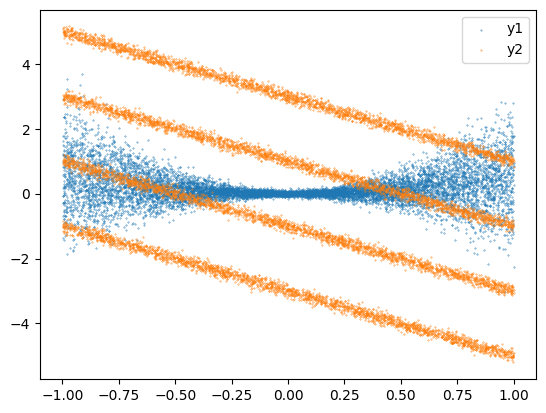

In [3]:
plt.scatter(x, y1, label="y1", s=0.1)
plt.scatter(x, y2, label="y2", s=0.1)
plt.legend()
plt.show()

In [4]:
from pcntoolkit import NormData

df = pd.DataFrame({"x": x, "y1": y1, "y2": y2, "be": be1})

normdata = NormData.from_dataframe(
    name="synth",
    dataframe=df,
    covariates=["x"],
    batch_effects=["be"],
    response_vars=["y1", "y2"],
)

Process: 79910 - 2025-11-13 14:45:38 - Dataset "synth" created.
    - 10000 observations
    - 10000 unique subjects
    - 1 covariates
    - 2 response variables
    - 1 batch effects:
    	be (4)
    


In [5]:
from pcntoolkit import (
    HBR,
    NormalLikelihood,
    make_prior,
    BsplineBasisFunction,
    LinearBasisFunction,
    BLR,
    NormativeModel,
)


model0 = NormativeModel(
    HBR(
        "fix_mu_fix_sigma",
        likelihood=NormalLikelihood(
            mu=make_prior(dist_name="Normal", dist_params=(0, 10)),
            sigma=make_prior(
                dist_name="Normal",
                dist_params=(0, 3),
                mapping="softplus",
                mapping_params=(0, 3),
            ),
        ),
    ),
    save_dir="../out/models/model_comparison/fix_mu_fix_sigma",
    name="fix_mu_fix_sigma",
)
model1 = NormativeModel(
    HBR(
        "fix_mu_bsp_sigma",
        likelihood=NormalLikelihood(
            mu=make_prior(dist_name="Normal", dist_params=(0, 10)),
            sigma=make_prior(
                linear=True,
                intercept=make_prior(),
                slope=make_prior(),
                mapping="softplus",
                mapping_params=(0, 3),
                basis_function=BsplineBasisFunction(),
            ),
        ),
    ),
    save_dir="../out/models/model_comparison/fix_mu_bsp_sigma",
    name="fix_mu_bsp_sigma",
)

model2 = NormativeModel(
    HBR(
        "bsp_mu_fix_sigma",
        likelihood=NormalLikelihood(
            mu=make_prior(
            linear=True,
            intercept=make_prior(),
            slope=make_prior(),
            basis_function=BsplineBasisFunction(),
        ),
        sigma=make_prior(
            dist_name="Normal",
            dist_params=(0, 10),
            mapping="softplus",
                mapping_params=(0, 3),
            ),
        ),
    ),
    save_dir="../out/models/model_comparison/bsp_mu_fix_sigma",
    name="bsp_mu_fix_sigma",
)

model3 = NormativeModel(
    HBR(
        "bsp_mu_bsp_sigma",
        likelihood=NormalLikelihood(
        mu=make_prior(
            linear=True,
            intercept=make_prior(),
            slope=make_prior(),
            basis_function=BsplineBasisFunction(),
        ),
        sigma=make_prior(
            linear=True,
            intercept=make_prior(),
            slope=make_prior(),
            mapping="softplus",
            mapping_params=(0, 3),
            basis_function=BsplineBasisFunction(),
            ),
        ),
    ),
    save_dir="../out/models/model_comparison/bsp_mu_bsp_sigma",
    name="bsp_mu_bsp_sigma",
)

model4 = NormativeModel(    
    HBR(
        "randbsp_mu_bsp_sigma",
    likelihood=NormalLikelihood(
        mu=make_prior(
            linear=True,
            intercept=make_prior(
                random=True,
                mu=make_prior(dist_params=(0, 3)),
                sigma=make_prior(
                    dist_params=(1, 1), mapping="softplus", mapping_params=(0, 1)
                ),
            ),
            slope=make_prior(),
            basis_function=BsplineBasisFunction(),
        ),
        sigma=make_prior(
            linear=True,
            intercept=make_prior(),
            slope=make_prior(),
            mapping="softplus",
            mapping_params=(0, 3),
            basis_function=BsplineBasisFunction(),
        ),
        ),
    ),
    save_dir="../out/models/model_comparison/randbsp_mu_bsp_sigma",
    name="randbsp_mu_bsp_sigma",
)

model5 = NormativeModel(    
    HBR(
        "randbsp_mu_fix_sigma",
    likelihood=NormalLikelihood(
        mu=make_prior(
            linear=True,
            intercept=make_prior(
                random=True,
                mu=make_prior(dist_params=(0, 3)),
                sigma=make_prior(
                    dist_params=(1, 1), mapping="softplus", mapping_params=(0, 1)
                ),
            ),
            slope=make_prior(),
            basis_function=BsplineBasisFunction(),
        ),
        sigma=make_prior(
            dist_params=(0, 3),
            mapping="softplus",
            mapping_params=(0, 3),
        ),
        ),
    ),
    save_dir="../out/models/model_comparison/randbsp_mu_fix_sigma",
    name="randbsp_mu_fix_sigma",
)

model6 = NormativeModel(    
    HBR(
        "randlin_mu_fixed_sigma",
    likelihood=NormalLikelihood(
        mu=make_prior(
            linear=True,
            intercept=make_prior(
                random=True,
                mu=make_prior(dist_params=(0, 3)),
                sigma=make_prior(
                    dist_params=(1, 1), mapping="softplus", mapping_params=(0, 1)
                ),
            ),
            slope=make_prior(),
            basis_function=LinearBasisFunction(),
        ),
        sigma=make_prior(
            dist_params=(0, 3),
            mapping="softplus",
            mapping_params=(0, 3),
        ),
        ),
    ),
    save_dir="../out/models/model_comparison/randlin_mu_fixed_sigma",
    name="randlin_mu_fixed_sigma",
)



In [ ]:
from typing import List
from pcntoolkit.regression_model.hbr import HBR


from pcntoolkit.normative_model import NormativeModel
import arviz as az
import pymc as pm
import pickle


def compare_hbr_models(models: dict[str, str]):
    """Compares HBR models

    Args:
        models (dict[str, str]): dictionary of [model name, path]

    Returns:
        dictionary of (responsevar, comparison): [str, dataframe]
    """

    loaded_models: dict[str, NormativeModel] = {}
    for k, v in models.items():
        try:
            m = NormativeModel.load(v)
            m.predict(m.synthesize(n_samples=10))
            loaded_models[k] = m
        except Exception as e:
            print("Cannot load model at location:", v, e)

    comparisons = {}
    for respvar in loaded_models[k].response_vars:
        traces = {}
        for name, model in loaded_models.items():
            with model[respvar].pymc_model:
                pm.compute_log_likelihood(model[respvar].idata)
            traces[name] = model[respvar].idata
        comparisons[respvar] = az.compare(traces)
    return comparisons



def fit_and_compare_models(models: List[NormativeModel], data: NormData):
    model_dict = {}
    for model in models:
        if "rand" in model.name:
            model.fit(data)
        model_dict[model.name] = model.save_dir
    print(len(model_dict))
    return compare_hbr_models(model_dict)


models = [model0, model1, model2, model3, model4, model5, model6]
comparison = fit_and_compare_models(models, normdata)
for k, v in comparison.items():
    print(k)
    display(v.round(3))
    print("-"*100)



Process: 41189 - 2025-11-13 14:12:00 - Fitting models on 2 response variables.
Process: 41189 - 2025-11-13 14:12:00 - Fitting model for y1.


KeyboardInterrupt: 

In [15]:
# pickle.dump(comparison, open("../out/models/model_comparison/comparison.pkl", "wb"))
pickle.load(open("../out/models/model_comparison/comparison.pkl", "rb"))['y1']


rank   elpd_loo     p_loo  elpd_diff        weight  \
bsp_mu_bsp_sigma           0  -8.215484  0.011690   0.000000  6.585936e-01   
randbsp_mu_bsp_sigma       1  -8.222249  0.017062   0.006765  4.900644e-15   
fix_mu_bsp_sigma           2  -8.737297  0.005612   0.521813  0.000000e+00   
fix_mu_fix_sigma           3 -12.881732  0.001310   4.666248  3.414064e-01   
bsp_mu_fix_sigma           4 -14.651159  0.006652   6.435675  0.000000e+00   
randbsp_mu_fix_sigma       5 -14.656787  0.010079   6.441303  0.000000e+00   
randlin_mu_fixed_sigma     6 -15.075485  0.006492   6.860001  6.017409e-14   

                              se       dse  warning scale  
bsp_mu_bsp_sigma        3.722900  0.000000    False   log  
randbsp_mu_bsp_sigma    3.722851  0.001541    False   log  
fix_mu_bsp_sigma        3.801249  0.101380    False   log  
fix_mu_fix_sigma        1.643029  5.155522    False   log  
bsp_mu_fix_sigma        2.104696  3.479607    False   log  
randbsp_mu_fix_sigma    2.105269  3.479687    False   log  
randlin_mu_fixed_sigma  2.104810  3.479694    False   log

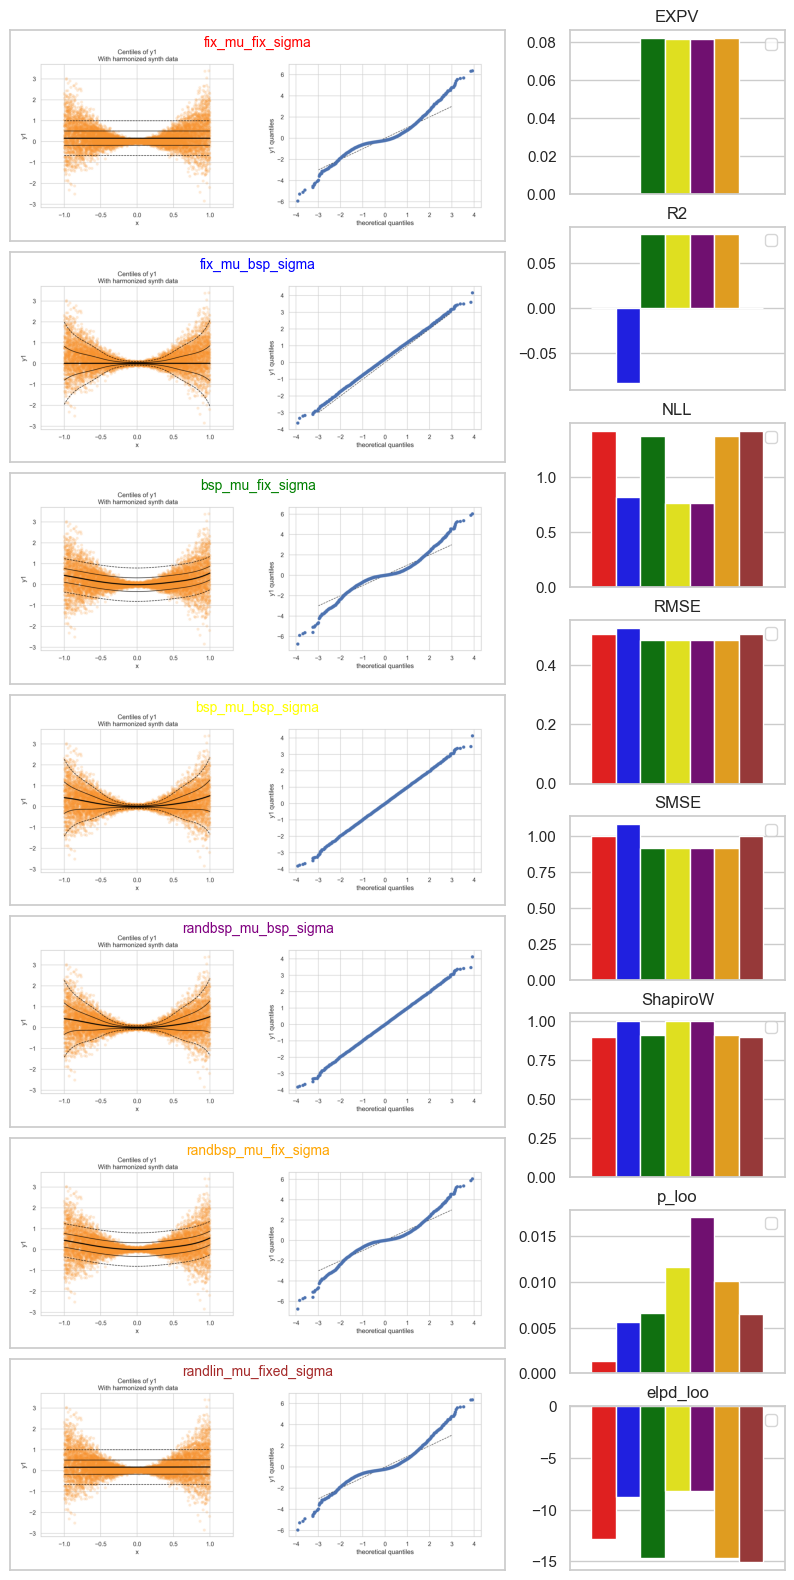

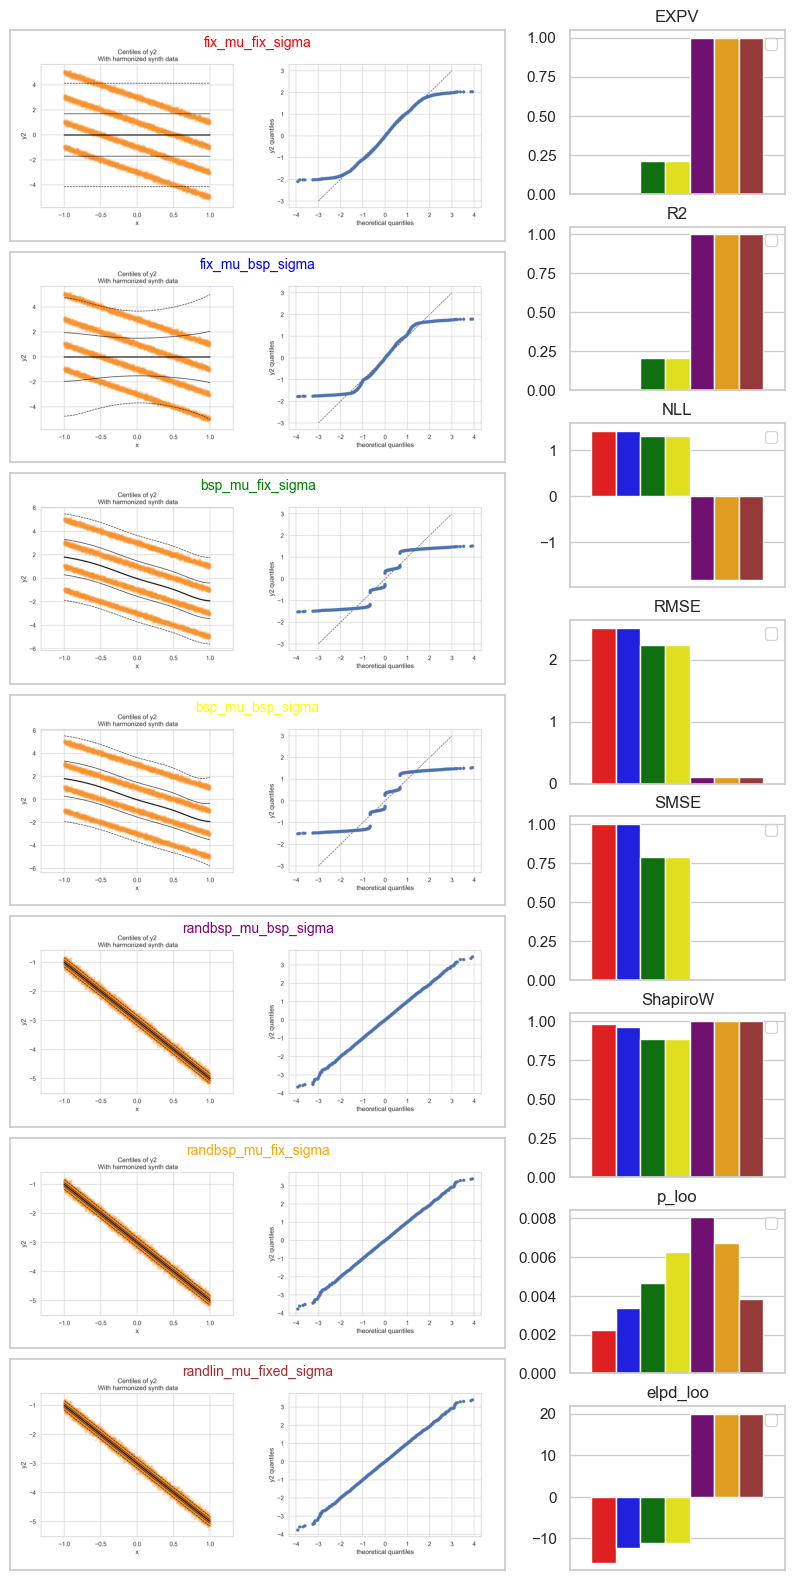

In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
statistics_to_plot = ["EXPV", "R2", "NLL", "RMSE",  "SMSE", "ShapiroW","p_loo", "elpd_loo"]
colors = ["red", "blue", "green", "yellow", "purple", "orange", "brown"]
for feature in ["y1", "y2"]:
    fig = plt.figure(figsize=(10, 20))
    gs0 = gridspec.GridSpec(1, 3, figure=fig, wspace=0.3)
    gs00 = gridspec.GridSpecFromSubplotSpec(7, 1, subplot_spec=gs0[0, 0:2], wspace=0, hspace=0.05)

    all_results = []
    for i, model in enumerate(models):
        centile_plot_path = os.path.join(model.save_dir, "plots", f"centiles_{feature}_synth_harmonized.png")
        qq_plot_path = os.path.join(model.save_dir, "plots", f"qq_{feature}_synth.png")

        results_path = os.path.join(model.save_dir, "results", "statistics_synth.csv")
        results = pd.read_csv(results_path)
        results = pd.concat([results, pd.DataFrame({"statistic":["p_loo", "elpd_loo"], "y1": comparison["y1"].loc[model.name, ["p_loo", "elpd_loo"]], "y2":comparison["y2"].loc[model.name,  ["p_loo", "elpd_loo"]]}).reset_index(drop=True)])
        results["model"] = i
        all_results.append(results)
        if os.path.exists(centile_plot_path):
            gs0i = gridspec.GridSpecFromSubplotSpec(1, 2,subplot_spec=gs00[i], wspace=0, hspace=0)
            ax_full = fig.add_subplot(gs0i[:], zorder=-3, facecolor="none")
            ax_full.set_xticks([],[])
            ax_full.set_yticks([],[])
            gs0isub = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs0i[:], wspace=0)
            ax_im = fig.add_subplot(gs0isub[0], zorder=-4)
            ax_im.imshow(Image.open(centile_plot_path))
            ax_im.axis("off")
            ax_im2 = fig.add_subplot(gs0isub[1], zorder=-4)
            ax_im2.imshow(Image.open(qq_plot_path))
            ax_im2.axis("off")
            if os.path.exists(results_path):
                results = pd.read_csv(results_path)
                model_color = colors[i]
                # Set text color to the color of the model
                # gs0i.set_title(model.name, color=model_color)
                # remove the axis title
                ax_full.set_title("")

                # draw on the figure instead — sits above EVERYTHING
                fig.text(
                    ax_full.get_position().x0 + ax_full.get_position().width/2,      # x position (left-aligned)
                    ax_full.get_position().y1 - 0.01,     # y position (slightly above the box)
                    model.name,
                    color=model_color,
                    fontsize=10,
                    ha="center",
                    va="bottom",
                    zorder=9999                             # bring it to the absolute top
                )
        else:
            print(f"Centile plot for {model.name} does not exist")
    all_results = pd.concat(all_results)
    all_results = all_results[all_results["statistic"].isin(statistics_to_plot)]
    all_results["model_color"] = all_results["model"].map(lambda x: colors[x])
    all_results["model_name"] = all_results["model"].map(lambda x: models[x].name)
    all_results['model'] = all_results['model'].astype(str)
    # ax_bar = fig.add_subplot(gs0[1])
    gs10 = gridspec.GridSpecFromSubplotSpec(len(statistics_to_plot), 1, subplot_spec=gs0[2], wspace=0)

    for i, stat in enumerate(statistics_to_plot):
        ax_bar = fig.add_subplot(gs10[i])
        sns.barplot(data=all_results[all_results["statistic"] == stat], ax=ax_bar, y=feature,  hue="model_name", palette=colors)
        ax_bar.set_title(stat)
        ax_bar.set_ylabel("")
        ax_bar.legend([],[])
    # plt.tight_layout()
    plt.show()



fix_mu_fix_sigma, y1


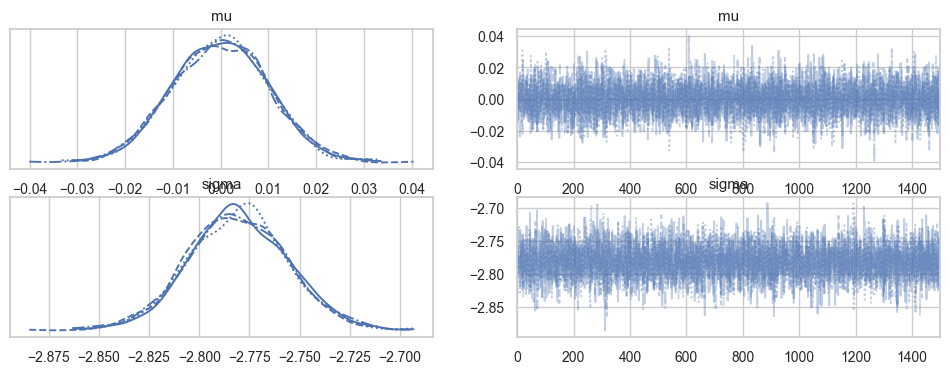

fix_mu_fix_sigma, y2


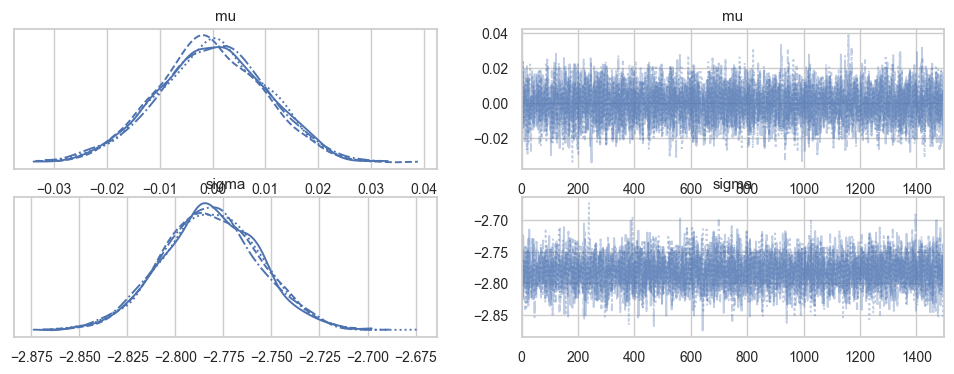

fix_mu_bsp_sigma, y1


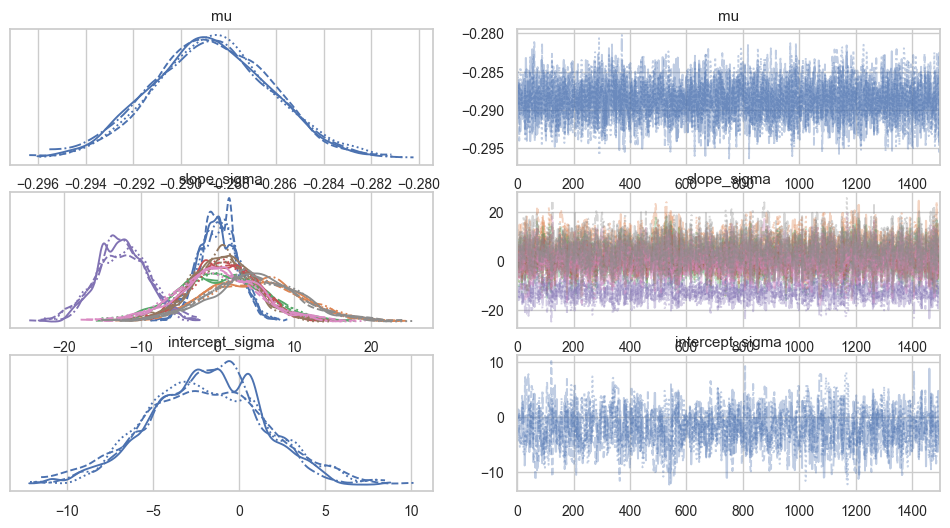

fix_mu_bsp_sigma, y2


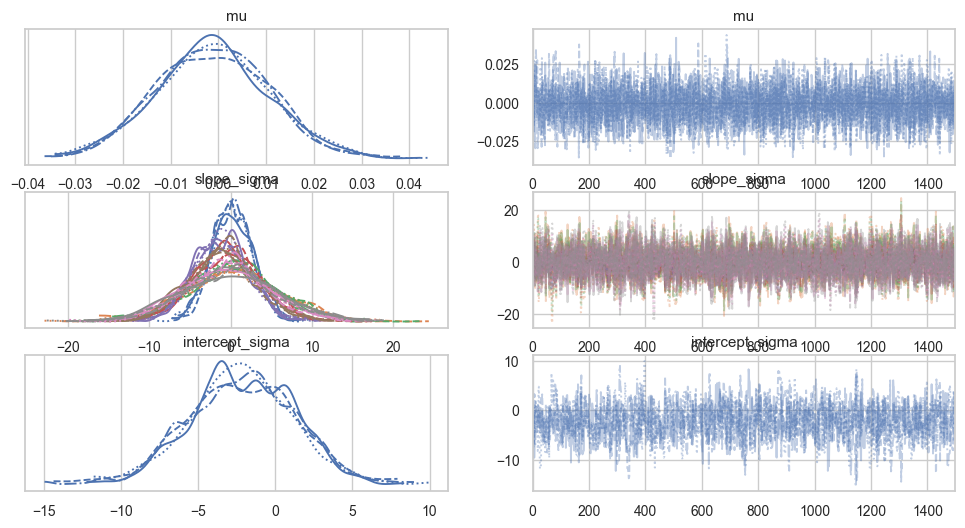

bsp_mu_fix_sigma, y1


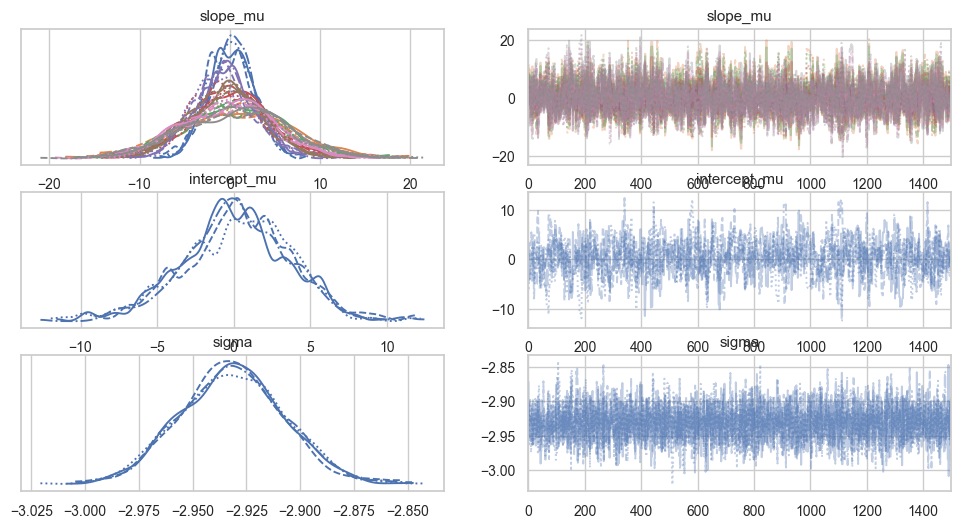

bsp_mu_fix_sigma, y2


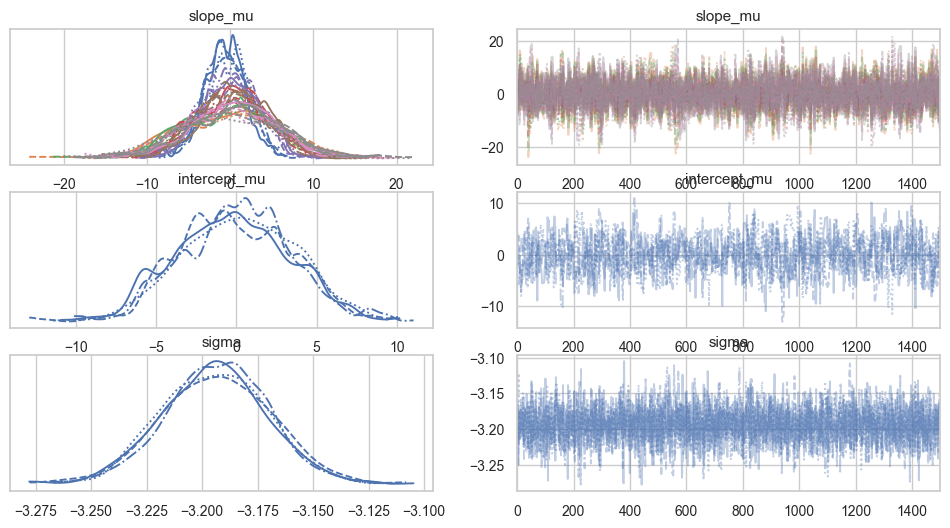

bsp_mu_bsp_sigma, y1


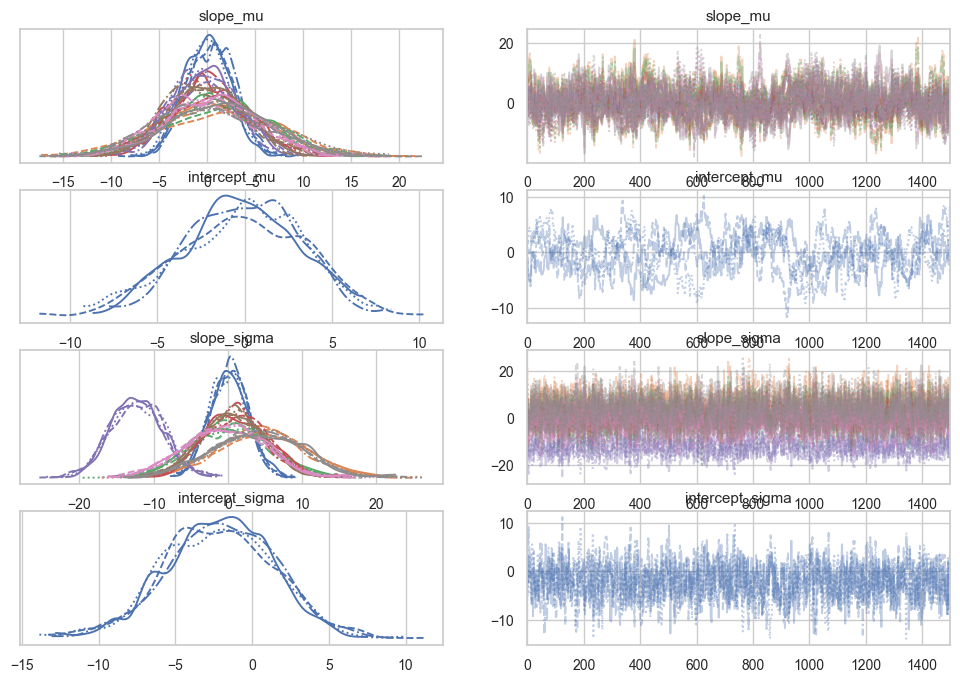

bsp_mu_bsp_sigma, y2


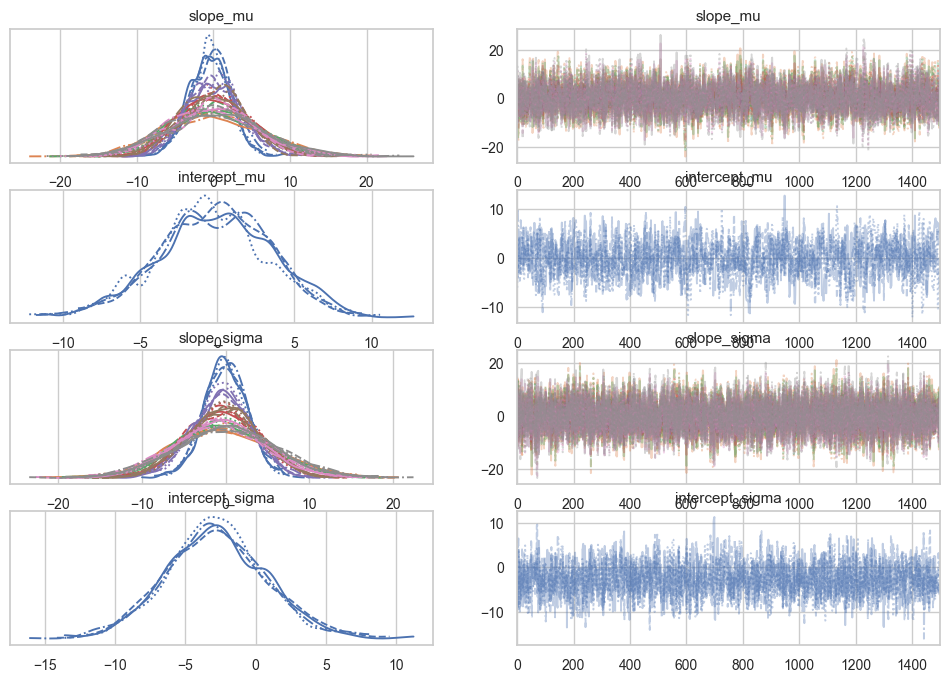

randbsp_mu_bsp_sigma, y1


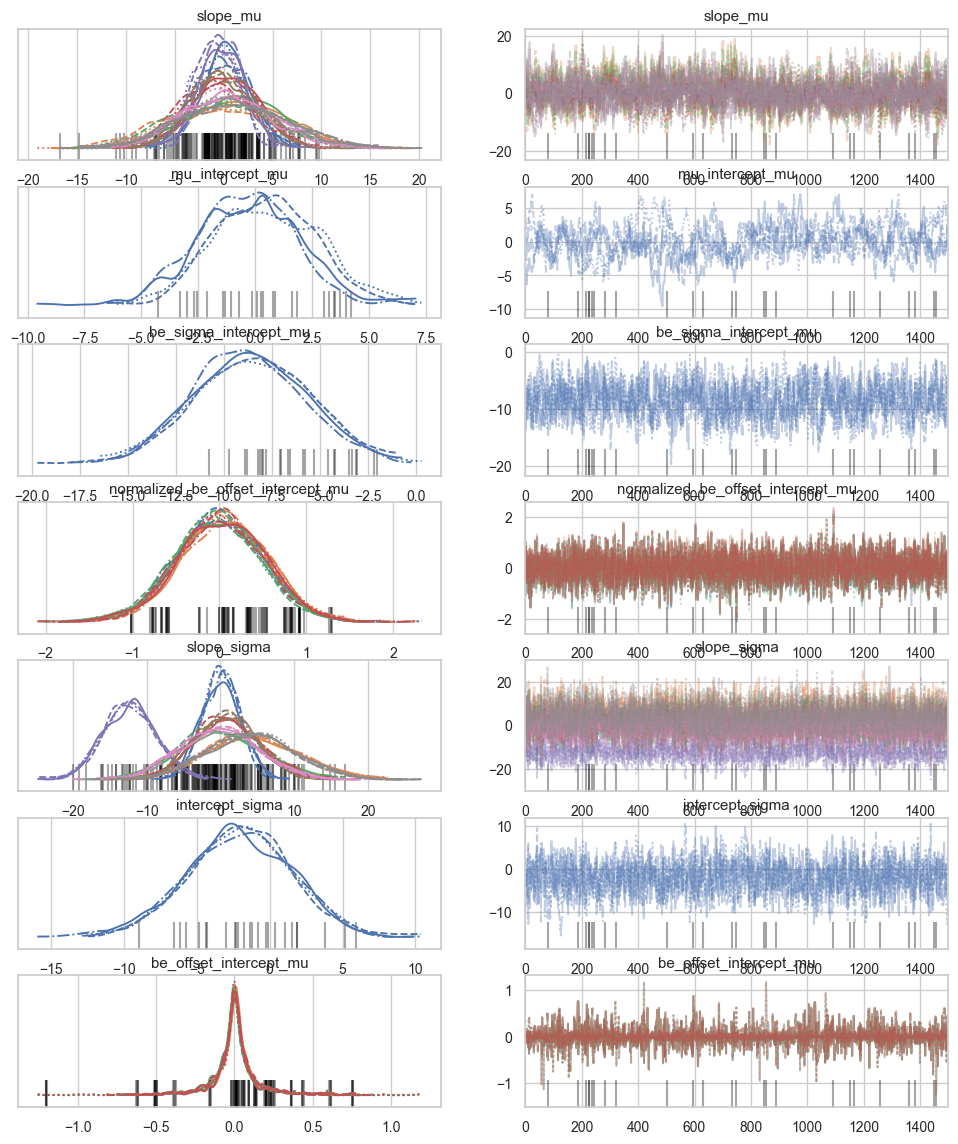

randbsp_mu_bsp_sigma, y2


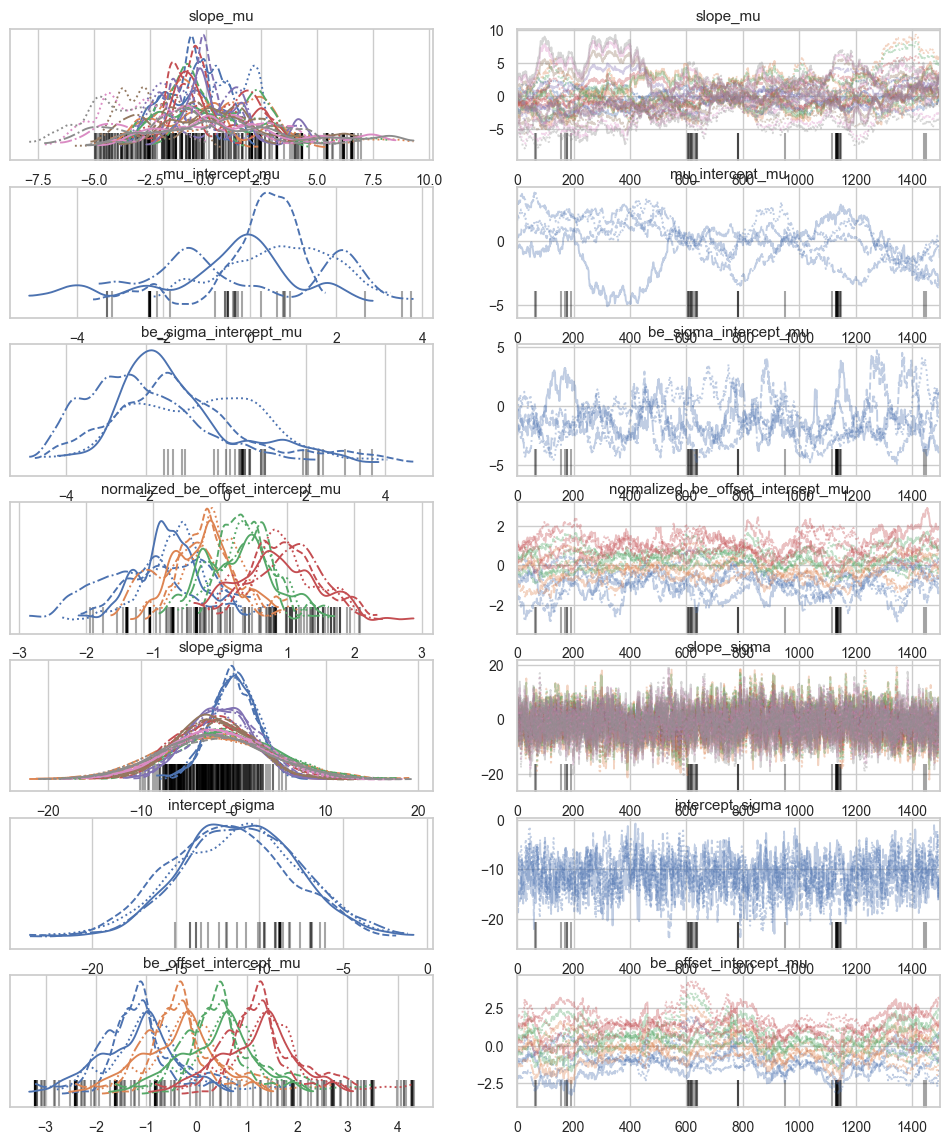

randbsp_mu_fix_sigma, y1


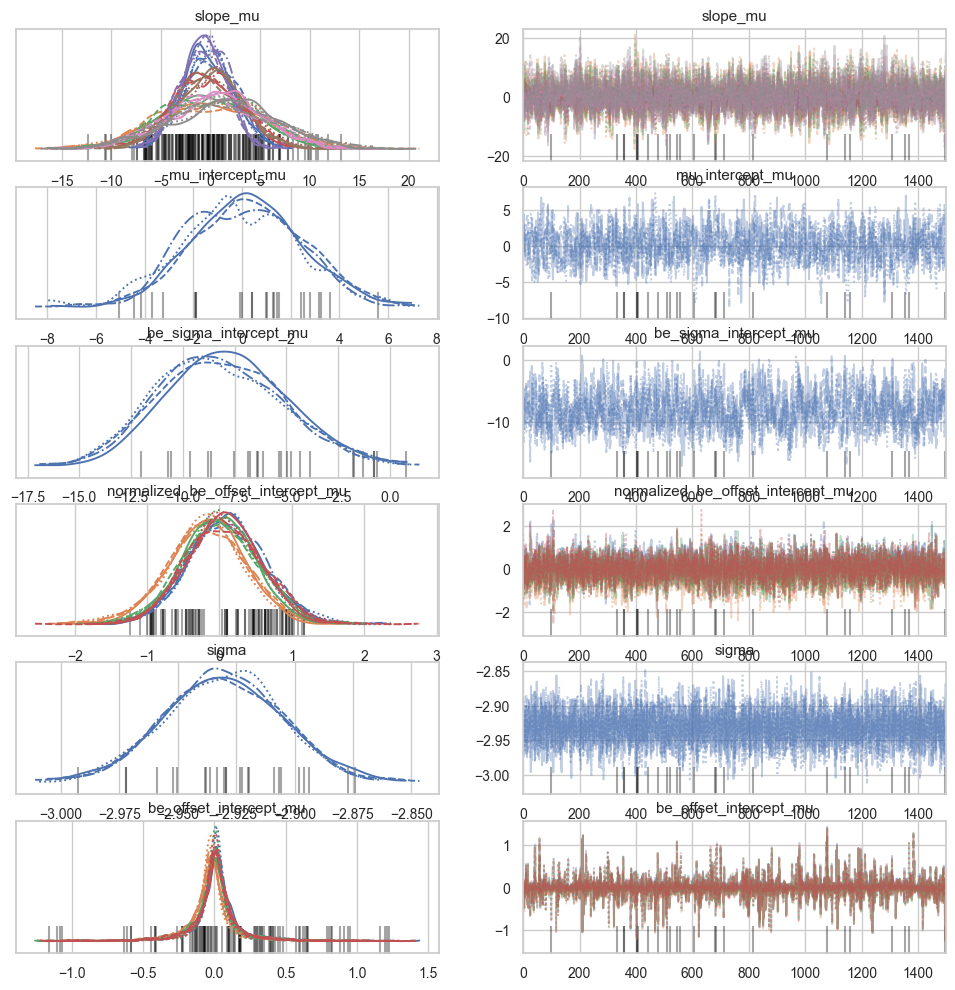

randbsp_mu_fix_sigma, y2


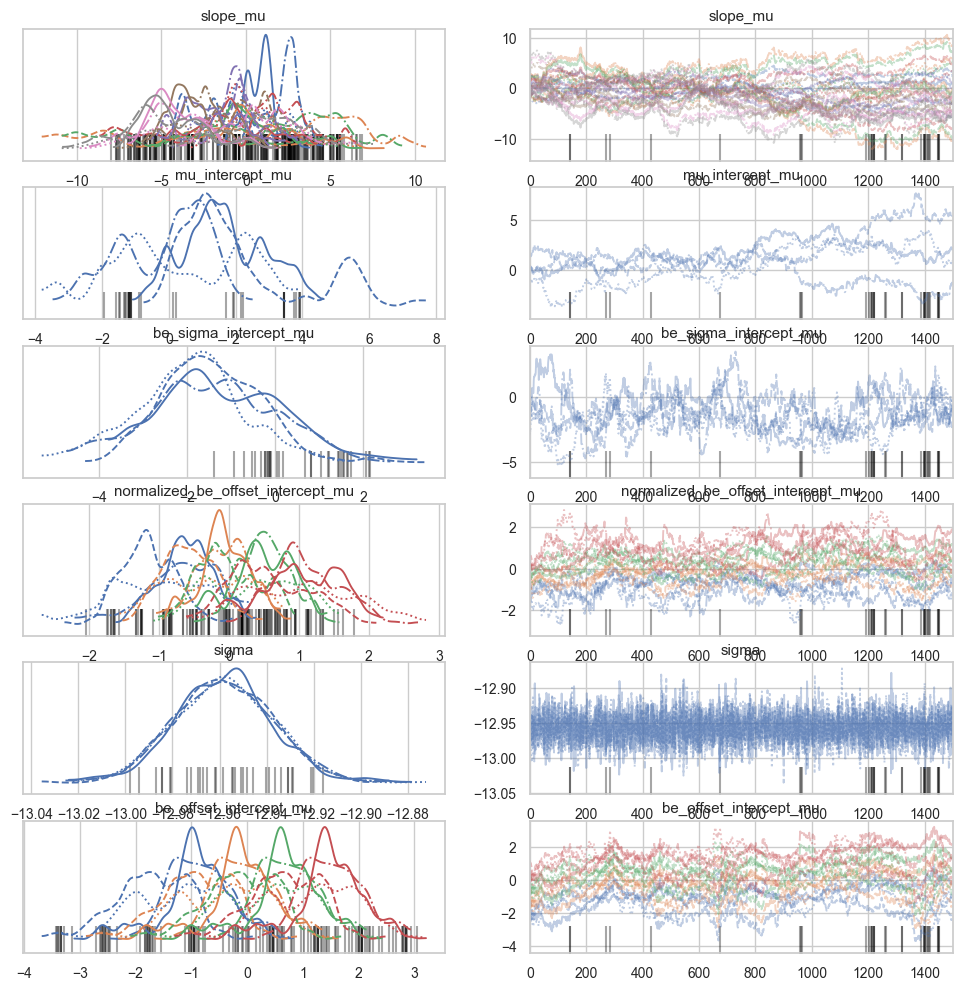

randlin_mu_fixed_sigma, y1


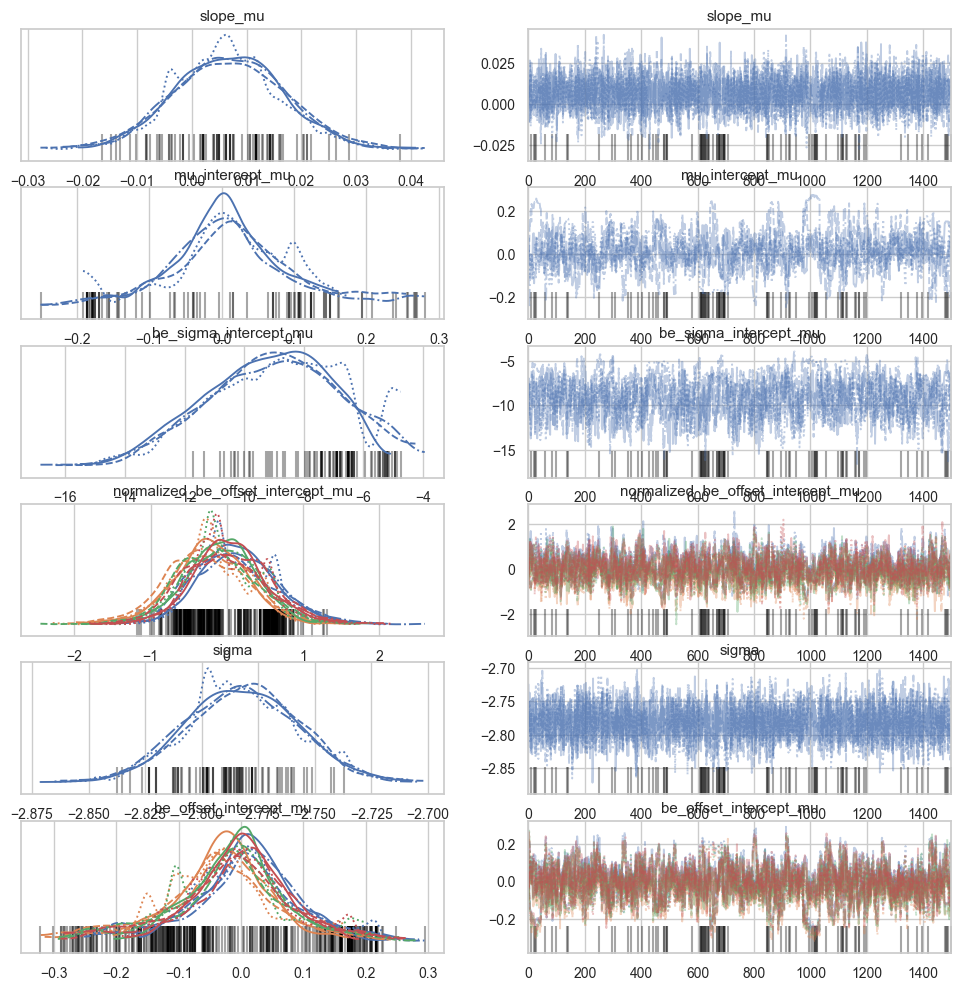

randlin_mu_fixed_sigma, y2


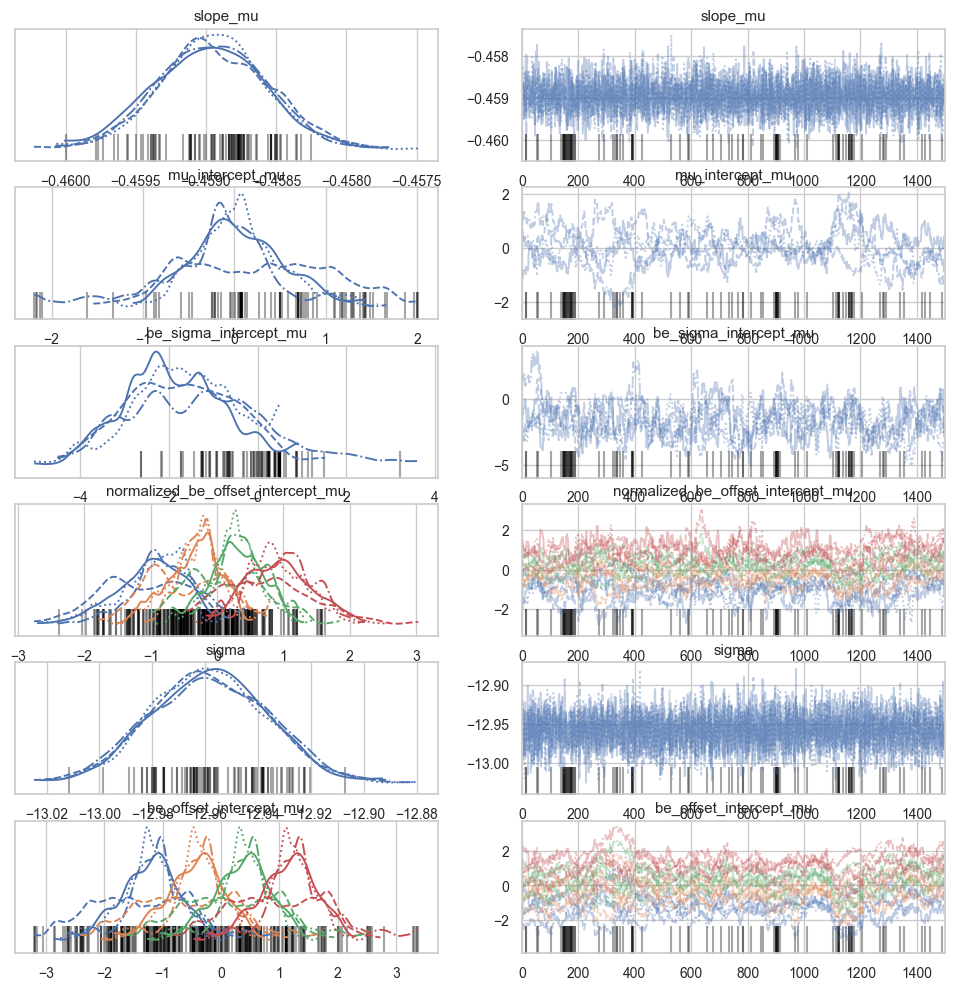

In [ ]:
for model in models:
    for respvar in model.response_vars:
        idata = az.from_netcdf(os.path.join(model.save_dir, "model", respvar, "idata.nc"))
        # print(f"{model.name}, {respvar}")
        fig = az.plot_trace(idata)        
        plt.show()

In [ ]:
all_results
# sns.barplot(data=all_results, x = "statistic")
all_results


statistic        y1        y2 model model_color              model_name
0       EXPV       0.0       0.0     0         red        fix_mu_fix_sigma
4        NLL  1.419038  1.419038     0         red        fix_mu_fix_sigma
5         R2      -0.0      -0.0     0         red        fix_mu_fix_sigma
6       RMSE   0.51588  1.156815     0         red        fix_mu_fix_sigma
9       SMSE       1.0       1.0     0         red        fix_mu_fix_sigma
10  ShapiroW  0.884118  0.958256     0         red        fix_mu_fix_sigma
0      p_loo  0.001304  0.002194     0         red        fix_mu_fix_sigma
0       EXPV       0.0       0.0     1        blue        fix_mu_bsp_sigma
4        NLL  0.799508  1.306723     1        blue        fix_mu_bsp_sigma
5         R2 -0.084358 -0.058312     1        blue        fix_mu_bsp_sigma
6       RMSE  0.537199  1.190066     1        blue        fix_mu_bsp_sigma
9       SMSE  1.084358  1.058312     1        blue        fix_mu_bsp_sigma
10  ShapiroW  0.999873  0.954383     1        blue        fix_mu_bsp_sigma
0      p_loo  0.005681  0.004824     1        blue        fix_mu_bsp_sigma
0       EXPV  0.085468  0.813414     2       green        bsp_mu_fix_sigma
4        NLL  1.374665  0.579907     2       green        bsp_mu_fix_sigma
5         R2  0.085468  0.813414     2       green        bsp_mu_fix_sigma
6       RMSE  0.493342  0.499693     2       green        bsp_mu_fix_sigma
9       SMSE  0.914532  0.186586     2       green        bsp_mu_fix_sigma
10  ShapiroW   0.89983  0.989071     2       green        bsp_mu_fix_sigma
0      p_loo  0.006901  0.004728     2       green        bsp_mu_fix_sigma
0       EXPV  0.084976  0.757025     3      yellow        bsp_mu_bsp_sigma
4        NLL  0.742566  0.241081     3      yellow        bsp_mu_bsp_sigma
5         R2  0.084976  0.757025     3      yellow        bsp_mu_bsp_sigma
6       RMSE  0.493475  0.570223     3      yellow        bsp_mu_bsp_sigma
9       SMSE  0.915024  0.242975     3      yellow        bsp_mu_bsp_sigma
10  ShapiroW  0.999931  0.990981     3      yellow        bsp_mu_bsp_sigma
0      p_loo  0.011976  0.010706     3      yellow        bsp_mu_bsp_sigma
0       EXPV  0.085204  0.992547     4      purple    randbsp_mu_bsp_sigma
4        NLL  0.742601 -1.030041     4      purple    randbsp_mu_bsp_sigma
5         R2  0.085203  0.992547     4      purple    randbsp_mu_bsp_sigma
6       RMSE  0.493413  0.099868     4      purple    randbsp_mu_bsp_sigma
9       SMSE  0.914797  0.007453     4      purple    randbsp_mu_bsp_sigma
10  ShapiroW  0.999933  0.999733     4      purple    randbsp_mu_bsp_sigma
0      p_loo  0.067437  0.041267     4      purple    randbsp_mu_bsp_sigma
0       EXPV  0.085725  0.992547     5      orange    randbsp_mu_fix_sigma
4        NLL  1.374668 -1.030083     5      orange    randbsp_mu_fix_sigma
5         R2  0.085725  0.992547     5      orange    randbsp_mu_fix_sigma
6       RMSE  0.493273  0.099868     5      orange    randbsp_mu_fix_sigma
9       SMSE  0.914275  0.007453     5      orange    randbsp_mu_fix_sigma
10  ShapiroW  0.899799  0.999739     5      orange    randbsp_mu_fix_sigma
0      p_loo  0.070401  0.039708     5      orange    randbsp_mu_fix_sigma
0       EXPV   0.05878  0.992546     6       brown  randlin_mu_fixed_sigma
4        NLL  1.388942 -1.030255     6       brown  randlin_mu_fixed_sigma
5         R2  0.058779  0.992546     6       brown  randlin_mu_fixed_sigma
6       RMSE  0.500489  0.099876     6       brown  randlin_mu_fixed_sigma
9       SMSE  0.941221  0.007454     6       brown  randlin_mu_fixed_sigma
10  ShapiroW  0.900391  0.999735     6       brown  randlin_mu_fixed_sigma
0      p_loo  0.044171   0.01608     6       brown  randlin_mu_fixed_sigma

In [ ]:
import os
from PIL import Image
import seaborn as sns
import matplotlib.gridspec as gridspec
statistics_to_plot = ["EXPV", "R2", "MSLL", "RMSE",  "SMSE", "ShapiroW"]
colors = ["red", "blue", "green", "yellow", "purple"]
for feature in ["y1", "y2"]:
    all_logp = []
    for i, model in enumerate(models):
        logp_path = os.path.join(model.save_dir, "results", "logp_synth.csv")
        if os.path.exists(logp_path):
            logp = pd.read_csv(logp_path)
            logp["model"] = i
            all_logp.append(logp)
    all_logp = pd.concat(all_logp)
    all_logp.drop(columns = ["y1" if feature == "y2" else "y2"], inplace=True)
    # display(all_logp)
    sns.kdeplot(data=all_logp, x="logp", hue="model", palette=colors)
    plt.show()



ValueError: Could not interpret value `logp` for `x`. An entry with this name does not appear in `data`.

In [ ]:
from pcntoolkit import BLR, NormativeModel
modelm1 = NormativeModel(BLR("blr"),
    save_dir="../out/models/model_comparison/blr",
    name="blr")


modelm1.fit(normdata)

modelm1.save_dir





Process: 40435 - 2025-11-13 09:17:19 - Fitting models on 2 response variables.
Process: 40435 - 2025-11-13 09:17:19 - Fitting model for y1.
Process: 40435 - 2025-11-13 09:17:19 - Fitting model for y2.
Process: 40435 - 2025-11-13 09:17:19 - Making predictions on 2 response variables.
Process: 40435 - 2025-11-13 09:17:19 - Computing z-scores for 2 response variables.
Process: 40435 - 2025-11-13 09:17:19 - Computing z-scores for y2.
Process: 40435 - 2025-11-13 09:17:19 - Computing z-scores for y1.
Process: 40435 - 2025-11-13 09:17:19 - Computing centiles for 2 response variables.
Process: 40435 - 2025-11-13 09:17:19 - Computing centiles for y2.
Process: 40435 - 2025-11-13 09:17:19 - Computing centiles for y1.
Process: 40435 - 2025-11-13 09:17:19 - Computing log-probabilities for 2 response variables.
Process: 40435 - 2025-11-13 09:17:19 - Computing log-probabilities for y2.
Process: 40435 - 2025-11-13 09:17:19 - Computing log-probabilities for y1.
Process: 40435 - 2025-11-13 09:17:19 - Co

/opt/anaconda3/envs/protocol/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 10000.
  res = hypotest_fun_out(*samples, **kwds)
/opt/anaconda3/envs/protocol/lib/python3.12/site-packages/pcntoolkit/dataio/norm_data.py:1083: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  subject_ids = subject_ids.stack(level="centile")


Process: 40435 - 2025-11-13 09:17:19 - Dataset "centile" created.
    - 150 observations
    - 150 unique subjects
    - 1 covariates
    - 2 response variables
    - 1 batch effects:
    	be (1)
    
Process: 40435 - 2025-11-13 09:17:19 - Computing centiles for 2 response variables.
Process: 40435 - 2025-11-13 09:17:19 - Computing centiles for y2.
Process: 40435 - 2025-11-13 09:17:19 - Computing centiles for y1.
Process: 40435 - 2025-11-13 09:17:19 - Harmonizing data on 2 response variables.
Process: 40435 - 2025-11-13 09:17:19 - Harmonizing data for y2.
Process: 40435 - 2025-11-13 09:17:19 - Harmonizing data for y1.
Process: 40435 - 2025-11-13 09:17:20 - Saving model to:
	../out/models/model_comparison/blr.


'../out/models/model_comparison/blr'

In [ ]:
modelm1 = NormativeModel.load("../out/models/model_comparison/blr")
modelm1.predict(normdata)

Process: 40435 - 2025-11-13 09:17:20 - Making predictions on 2 response variables.
Process: 40435 - 2025-11-13 09:17:20 - Computing z-scores for 2 response variables.
Process: 40435 - 2025-11-13 09:17:20 - Computing z-scores for y2.
Process: 40435 - 2025-11-13 09:17:20 - Computing z-scores for y1.
Process: 40435 - 2025-11-13 09:17:20 - Computing centiles for 2 response variables.
Process: 40435 - 2025-11-13 09:17:20 - Computing centiles for y2.
Process: 40435 - 2025-11-13 09:17:20 - Computing centiles for y1.
Process: 40435 - 2025-11-13 09:17:20 - Computing log-probabilities for 2 response variables.
Process: 40435 - 2025-11-13 09:17:20 - Computing log-probabilities for y2.
Process: 40435 - 2025-11-13 09:17:20 - Computing log-probabilities for y1.
Process: 40435 - 2025-11-13 09:17:20 - Computing yhat for 2 response variables.
Process: 40435 - 2025-11-13 09:17:20 - Computing yhat for y2.
Process: 40435 - 2025-11-13 09:17:20 - Computing yhat for y1.


/opt/anaconda3/envs/protocol/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 10000.
  res = hypotest_fun_out(*samples, **kwds)
/opt/anaconda3/envs/protocol/lib/python3.12/site-packages/pcntoolkit/dataio/norm_data.py:1083: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  subject_ids = subject_ids.stack(level="centile")


Process: 40435 - 2025-11-13 09:17:21 - Dataset "centile" created.
    - 150 observations
    - 150 unique subjects
    - 1 covariates
    - 2 response variables
    - 1 batch effects:
    	be (1)
    
Process: 40435 - 2025-11-13 09:17:21 - Computing centiles for 2 response variables.
Process: 40435 - 2025-11-13 09:17:21 - Computing centiles for y2.
Process: 40435 - 2025-11-13 09:17:21 - Computing centiles for y1.
Process: 40435 - 2025-11-13 09:17:21 - Harmonizing data on 2 response variables.
Process: 40435 - 2025-11-13 09:17:21 - Harmonizing data for y2.
Process: 40435 - 2025-11-13 09:17:21 - Harmonizing data for y1.


<xarray.NormData> Size: 3MB
Dimensions:            (observations: 10000, response_vars: 2, covariates: 1,
                        batch_effect_dims: 1, statistic: 11, centile: 5)
Coordinates:
  * observations       (observations) int64 80kB 0 1 2 3 ... 9996 9997 9998 9999
  * response_vars      (response_vars) <U2 16B 'y1' 'y2'
  * covariates         (covariates) <U1 4B 'x'
  * batch_effect_dims  (batch_effect_dims) <U2 8B 'be'
  * statistic          (statistic) <U8 352B 'EXPV' 'MACE' ... 'SMSE' 'ShapiroW'
  * centile            (centile) float64 40B 0.05 0.25 0.5 0.75 0.95
Data variables:
    subject_ids        (observations) int64 80kB 0 1 2 3 ... 9996 9997 9998 9999
    Y                  (observations, response_vars) float64 160kB -1.128 ......
    X                  (observations, covariates) float64 80kB -0.9996 ... 0....
    batch_effects      (observations, batch_effect_dims) <U21 840kB '0' ... '0'
    Z                  (observations, response_vars) float64 160kB -2.569 ......
    logp               (observations, response_vars) float64 160kB -4.22 ... ...
    Yhat               (observations, response_vars) float64 160kB 0.1721 ......
    statistics         (response_vars, statistic) float64 176B 1.094e-10 ... ...
    Y_harmonized       (observations, response_vars) float64 160kB -1.128 ......
    centiles           (centile, observations, response_vars) float64 800kB -...
Attributes:
    real_ids:                       False
    is_scaled:                      False
    name:                           synth
    unique_batch_effects:           {np.str_('be'): [np.str_('0'), np.str_('1...
    batch_effect_counts:            defaultdict(<function NormData.register_b...
    covariate_ranges:               {np.str_('x'): {'mean': np.float64(0.0047...
    batch_effect_covariate_ranges:  {np.str_('be'): {np.str_('0'): {np.str_('...

In [ ]:
model0 = NormativeModel.load("../out/models/model_comparison/fixed_mu_and_sigma")
model0.predict(normdata)

AssertionError: Path ../out/models/model_comparison/fixed_mu_and_sigma does not exist

In [ ]:
from pcntoolkit import BLR, NormativeModel, NormData
modelblr = NormativeModel.load("../out/models/model_comparison/blr")
modelblr.predict(normdata)

Process: 23222 - 2025-11-12 13:31:15 - Making predictions on 2 response variables.
Process: 23222 - 2025-11-12 13:31:15 - Computing z-scores for 2 response variables.
Process: 23222 - 2025-11-12 13:31:15 - Computing z-scores for y2.
Process: 23222 - 2025-11-12 13:31:15 - Computing z-scores for y1.
Process: 23222 - 2025-11-12 13:31:15 - Computing centiles for 2 response variables.
Process: 23222 - 2025-11-12 13:31:15 - Computing centiles for y2.
Process: 23222 - 2025-11-12 13:31:15 - Computing centiles for y1.
Process: 23222 - 2025-11-12 13:31:15 - Computing log-probabilities for 2 response variables.
Process: 23222 - 2025-11-12 13:31:15 - Computing log-probabilities for y2.
-1 <xarray.DataArray 'logp' ()> Size: 8B
array(-0.69607016)
Coordinates:
    response_vars  <U2 8B 'y2'
Process: 23222 - 2025-11-12 13:31:15 - Computing log-probabilities for y1.
-1 <xarray.DataArray 'logp' ()> Size: 8B
array(-1.42649907)
Coordinates:
    response_vars  <U2 8B 'y1'
0 <xarray.DataArray 'logp' ()> Siz

/opt/anaconda3/envs/protocol/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 10000.
  res = hypotest_fun_out(*samples, **kwds)
/opt/anaconda3/envs/protocol/lib/python3.12/site-packages/pcntoolkit/dataio/norm_data.py:1083: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  subject_ids = subject_ids.stack(level="centile")


4 <xarray.DataArray 'logp' ()> Size: 8B
array(-1.06128461)
Process: 23222 - 2025-11-12 13:31:16 - Dataset "centile" created.
    - 150 observations
    - 150 unique subjects
    - 1 covariates
    - 2 response variables
    - 1 batch effects:
    	be (1)
    
Process: 23222 - 2025-11-12 13:31:16 - Computing centiles for 2 response variables.
Process: 23222 - 2025-11-12 13:31:16 - Computing centiles for y2.
Process: 23222 - 2025-11-12 13:31:16 - Computing centiles for y1.
Process: 23222 - 2025-11-12 13:31:16 - Harmonizing data on 2 response variables.
Process: 23222 - 2025-11-12 13:31:16 - Harmonizing data for y2.
Process: 23222 - 2025-11-12 13:31:16 - Harmonizing data for y1.


<xarray.NormData> Size: 3MB
Dimensions:            (observations: 10000, response_vars: 2, covariates: 1,
                        batch_effect_dims: 1, centile: 5, statistic: 11)
Coordinates:
  * observations       (observations) int64 80kB 0 1 2 3 ... 9996 9997 9998 9999
  * response_vars      (response_vars) <U2 16B 'y1' 'y2'
  * covariates         (covariates) <U1 4B 'x'
  * batch_effect_dims  (batch_effect_dims) <U2 8B 'be'
  * centile            (centile) float64 40B 0.05 0.25 0.5 0.75 0.95
  * statistic          (statistic) <U8 352B 'EXPV' 'MACE' ... 'SMSE' 'ShapiroW'
Data variables:
    subject_ids        (observations) int64 80kB 0 1 2 3 ... 9996 9997 9998 9999
    Y                  (observations, response_vars) float64 160kB 0.1257 ......
    X                  (observations, covariates) float64 80kB -0.9998 ... 0....
    batch_effects      (observations, batch_effect_dims) <U21 840kB '0' ... '3'
    Z                  (observations, response_vars) float64 160kB -0.4203 .....
    centiles           (centile, observations, response_vars) float64 800kB -...
    logp               (observations, response_vars) float64 160kB -1.007 ......
    Yhat               (observations, response_vars) float64 160kB 0.3661 ......
    statistics         (response_vars, statistic) float64 176B -0.001098 ... ...
    Y_harmonized       (observations, response_vars) float64 160kB 0.1257 ......
Attributes:
    real_ids:                       False
    is_scaled:                      False
    name:                           synth
    unique_batch_effects:           {np.str_('be'): [np.str_('0'), np.str_('1...
    batch_effect_counts:            defaultdict(<function NormData.register_b...
    covariate_ranges:               {np.str_('x'): {'mean': np.float64(-0.008...
    batch_effect_covariate_ranges:  {np.str_('be'): {np.str_('0'): {np.str_('...

In [ ]:
from pcntoolkit import plot_centiles
slice_size = 500
myslice = normdata.isel({"observations":np.random.choice(len(normdata.X), slice_size, replace=False)})

a = min(1, 20/np.sqrt(len(myslice.X)))
plot_centiles(modelblr, myslice, scatter_kwargs= {"alpha":a, "s":12})
len(normdata.X)

NameError: name 'modelblr' is not defined

In [16]:
model

NameError: name 'model' is not defined

In [7]:
model = NormativeModel.load(model1.save_dir)
model.predict(normdata)
model.model_specific_evaluation()

Sampling: []


Process: 79910 - 2025-11-13 14:46:12 - Making predictions on 2 response variables.
Process: 79910 - 2025-11-13 14:46:12 - Computing z-scores for 2 response variables.
Process: 79910 - 2025-11-13 14:46:12 - Computing z-scores for y2.


Sampling: []


Process: 79910 - 2025-11-13 14:46:14 - Computing z-scores for y1.


Sampling: []


Process: 79910 - 2025-11-13 14:46:16 - Computing centiles for 2 response variables.
Process: 79910 - 2025-11-13 14:46:16 - Computing centiles for y2.


Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []


Process: 79910 - 2025-11-13 14:46:23 - Computing centiles for y1.


Sampling: []
Sampling: []
Sampling: []
Sampling: []


Process: 79910 - 2025-11-13 14:46:31 - Computing log-probabilities for 2 response variables.
Process: 79910 - 2025-11-13 14:46:31 - Computing log-probabilities for y2.
Process: 79910 - 2025-11-13 14:46:32 - Computing log-probabilities for y1.


Sampling: []


Process: 79910 - 2025-11-13 14:46:34 - Computing yhat for 2 response variables.


Sampling: []
/opt/anaconda3/envs/protocol/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 10000.
  res = hypotest_fun_out(*samples, **kwds)
/opt/anaconda3/envs/protocol/lib/python3.12/site-packages/pcntoolkit/util/evaluator.py:273: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho, p_rho = stats.spearmanr(y, yhat)
/opt/anaconda3/envs/protocol/lib/python3.12/site-packages/pcntoolkit/dataio/norm_data.py:1083: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  subject_ids = subject_ids.stack(level="centile")
Sampling: []
Sampling: []


Process: 79910 - 2025-11-13 14:46:36 - Dataset "centile" created.
    - 150 observations
    - 150 unique subjects
    - 1 covariates
    - 2 response variables
    - 1 batch effects:
    	be (1)
    
Process: 79910 - 2025-11-13 14:46:36 - Computing centiles for 2 response variables.
Process: 79910 - 2025-11-13 14:46:36 - Computing centiles for y2.


Sampling: []
Sampling: []
Sampling: []
Sampling: []
Sampling: []


Process: 79910 - 2025-11-13 14:46:37 - Computing centiles for y1.


Sampling: []
Sampling: []
Sampling: []
Sampling: []


Process: 79910 - 2025-11-13 14:46:37 - Harmonizing data on 2 response variables.
Process: 79910 - 2025-11-13 14:46:37 - Harmonizing data for y2.


Sampling: []
Sampling: []


Process: 79910 - 2025-11-13 14:46:40 - Harmonizing data for y1.


Sampling: []
/opt/anaconda3/envs/protocol/lib/python3.12/site-packages/arviz/utils.py:146: UserWarning: Items starting with ~: ['_per_subject'] have not been found and will be ignored
  warnings.warn(
/opt/anaconda3/envs/protocol/lib/python3.12/site-packages/arviz/utils.py:146: UserWarning: Items starting with ~: ['_per_subject'] have not been found and will be ignored
  warnings.warn(
/opt/anaconda3/envs/protocol/lib/python3.12/site-packages/arviz/utils.py:146: UserWarning: Items starting with ~: ['_per_subject'] have not been found and will be ignored
  warnings.warn(
/opt/anaconda3/envs/protocol/lib/python3.12/site-packages/arviz/utils.py:146: UserWarning: Items starting with ~: ['_per_subject'] have not been found and will be ignored
  warnings.warn(
/opt/anaconda3/envs/protocol/lib/python3.12/site-packages/arviz/utils.py:146: UserWarning: Items starting with ~: ['_per_subject'] have not been found and will be ignored
  warnings.warn(
/opt/anaconda3/envs/protocol/lib/python3.12/sit